In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools

%matplotlib inline

In [2]:
'''
13. Write functions that compute the RBF kernel k[RBF(sigma)](x,x') = exp-∥x-x'∥2/ 2xsigma^2 and the polynomial kernel kpoly(a,d)(x,x') = (a + ⟨x,x'⟩)d. 
The linear kernel klinear(x,x') = ⟨x, x'⟩, has been done for you in the support code. 
Your functions should take as input two matrices W ∈ Rn1xd and X ∈ Rn2xd and should return a matrix M ∈ Rn1xn2 where Mij = k(Wi·,Xj·). 
In words, the (i,j)'th entry of M should be kernel evaluation between wi (the ith row of W) and xj (the jth row of X). 
For the RBF kernel, you may use the scipy function cdist(X1,X2,'sqeuclidean') in the package scipy.spatial.distance.
'''
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    sq_euclidean_dist = scipy.spatial.distance.cdist(X1, X2, 'sqeuclidean')
    return np.exp((-1)*(1/(2*sigma*sigma))*sq_euclidean_dist)

def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (np.dot(X1,np.transpose(X2)) + offset)**degree


In [3]:
'''14. Use the linear kernel function defined in the code to compute the kernel matrix on the set of points x0 ∈ DX = {-4,-1,0,2}. Include both the code and the output.'''
linear_kernel(np.array([[-4], [-1], [0], [2]]), np.array([[-4], [-1], [0], [2]]))

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

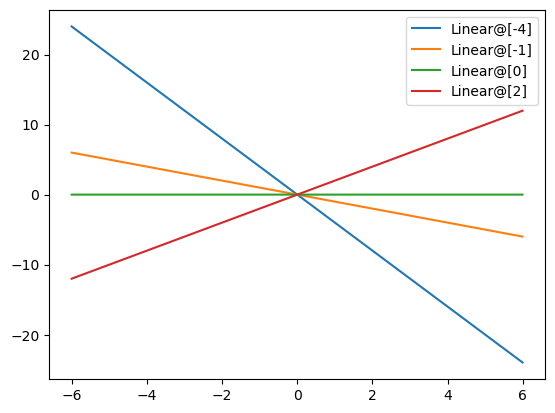

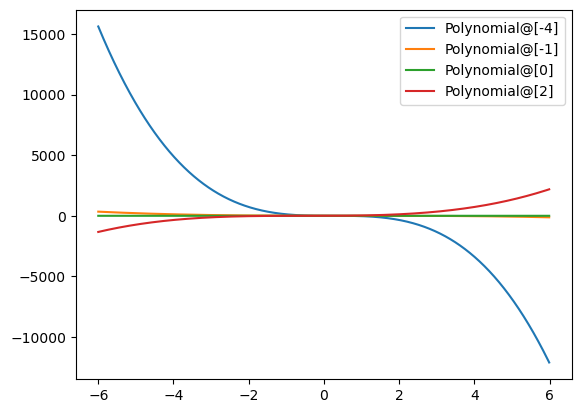

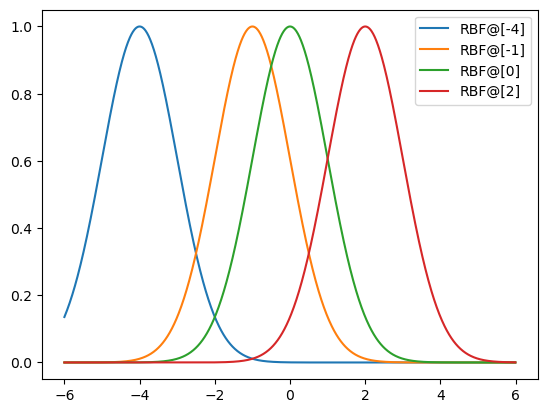

In [4]:
# PLot kernel machine functions
'''
15. Suppose we have the data set DX,y = {(-4,2),(-1,0),(0,3),(2,5)} (in each set of parentheses, the first number is the value of xi and the second number the corresponding value
of the target yi). Then by the representer theorem, the final prediction function will be in the span of the functions x → k(x0,x) for x0 ∈ DX = {-4,-1,0,2}. 
This set of functions will look quite different depending on the kernel function we use. 
The set of functions x → klinear(x0,x) for x0 ∈ DX and for x ∈ [-6,6] has been provided for the linear kernel. 
(a) Plot the set of functions x → kpoly(1,3)(x0,x) for x0 ∈ DX and for x ∈ [-6,6]. 
(b) Plot the set of functions x → kRBF(1)(x0,x) for x0 ∈ DX and for x ∈ [-6,6]. 
Note that the values of the parameters of the kernels you should use are given in their definitions in (a) and (b).
'''
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()

# Polynomial kernel
y = polynomial_kernel(prototypes, xpts, offset=1, degree=3) 
for i in range(len(prototypes)):
    label = "Polynomial@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()

# RBF kernel
y = RBF_kernel(prototypes, xpts, sigma= 1) 
for i in range(len(prototypes)):
    label = "RBF@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()

In [5]:
'''
16. By the representer theorem, the final prediction function will be of the form f(x) = sum(i = 1 ... n) alpha_i.k(xi,x), where x1,...,xn ∈ X are the inputs in the training set. 
We will use the class Kernel Machine in the skeleton code to make prediction with different kernels. 
Complete the predict function of the class Kernel Machine. 
Construct a Kernel Machine object with the RBF kernel (sigma=1), with prototype points at -1,0,1 and corresponding weights alpha_i 1,-1,1. 
Plot the resulting function.
'''

class Kernel_Machine(object):
    def __init__(self, kernel, training_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            training_points - an nxd matrix with rows x_1,..., x_n
            weights - a vector of length n with entries alpha_1,...,alpha_n
        """

        self.kernel = kernel
        self.training_points = training_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R alpha_i k(x_j, mu_i)
        """
        K = self.kernel(X, self.training_points)
        return np.dot(K,self.weights)

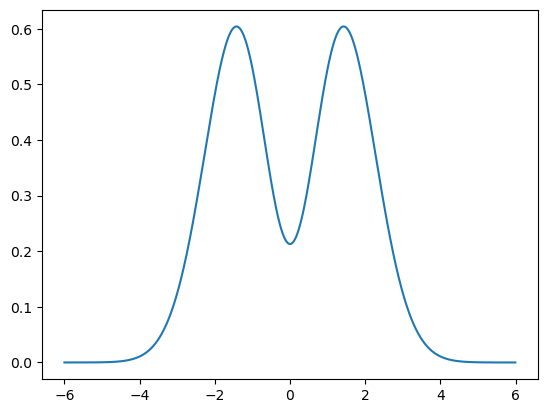

In [6]:
prototypes = np.array([-1, 0, 1]).reshape(-1,1)
weights = np.array([1, -1, 1]).reshape(-1, 1)

Fx = Kernel_Machine(kernel= (lambda i, j : RBF_kernel(X1 = i, X2 = j, sigma=1)), training_points= prototypes, weights=weights)

plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
plt.plot(xpts, Fx.predict(xpts))
plt.show() 